In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



In [2]:
print(np.__version__)

1.20.3


In [3]:


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)



### lets try and load the sophronia stuff here

In [4]:
# loading sophronia file
soph_file = f'../LPR/208Tl/PORT_1a/prod/sophronia/sophronia/sophronia_180_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh
display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580000,3.580001e+12,0,-148.667262,364.111673,1,-272.125,147.725,0.0,0.0,374.378021,7.246377,765.075420,-1.0,0.002455,-1,-1.0
1,3580000,3.580001e+12,0,-148.667262,364.111673,1,-272.125,163.275,0.0,0.0,374.378021,5.043478,532.492472,-1.0,0.001720,-1,-1.0
2,3580000,3.580001e+12,0,-148.667262,364.111673,1,-256.575,147.725,0.0,0.0,374.378021,5.739130,605.939696,-1.0,0.001951,-1,-1.0
3,3580000,3.580001e+12,0,-148.667262,364.111673,1,-256.575,163.275,0.0,0.0,374.378021,5.043478,532.492472,-1.0,0.001721,-1,-1.0
4,3580000,3.580001e+12,0,-148.667262,364.111673,1,-272.125,147.725,0.0,0.0,375.409210,13.159420,597.688660,-1.0,0.001918,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175387,3580710,3.580712e+12,0,373.853623,76.970409,1,194.375,132.175,0.0,0.0,695.576599,8.869565,627.508728,-1.0,0.002034,-1,-1.0
175388,3580710,3.580712e+12,0,373.853623,76.970409,1,194.375,147.725,0.0,0.0,695.576599,6.260870,442.947357,-1.0,0.001432,-1,-1.0
175389,3580710,3.580712e+12,0,373.853623,76.970409,1,163.275,132.175,0.0,0.0,696.634155,7.072464,723.569092,-1.0,0.002337,-1,-1.0
175390,3580710,3.580712e+12,0,373.853623,76.970409,1,194.375,132.175,0.0,0.0,696.634155,7.188406,735.430908,-1.0,0.002384,-1,-1.0


### And convert to the lowTh files

In [5]:
def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process

    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

        

### heres a demonstration of doing it with a singular event

In [6]:
# convert to hitcollection
soph_hits = hits_from_df(soph_hdst)

In [7]:
print(soph_hits.keys())
# collect keys
soph_hits_list = list(soph_hits.keys())
# choose event to look at
event = 1
event_soph_hits = soph_hits_list[event]
# show the output print from this
print("")
print(event_soph_hits)
soph_hit_event = soph_hits.get(event_soph_hits)
print(soph_hit_event)




dict_keys([3580000, 3580002, 3580004, 3580006, 3580008, 3580010, 3580012, 3580014, 3580016, 3580018, 3580020, 3580022, 3580024, 3580026, 3580028, 3580030, 3580032, 3580034, 3580036, 3580038, 3580040, 3580042, 3580044, 3580046, 3580048, 3580052, 3580054, 3580056, 3580058, 3580060, 3580062, 3580064, 3580066, 3580068, 3580070, 3580072, 3580074, 3580076, 3580078, 3580080, 3580082, 3580084, 3580086, 3580088, 3580090, 3580092, 3580094, 3580096, 3580098, 3580100, 3580102, 3580106, 3580108, 3580110, 3580112, 3580114, 3580116, 3580118, 3580120, 3580122, 3580124, 3580126, 3580128, 3580130, 3580132, 3580134, 3580136, 3580138, 3580140, 3580142, 3580144, 3580146, 3580148, 3580150, 3580152, 3580154, 3580156, 3580158, 3580160, 3580162, 3580164, 3580166, 3580168, 3580170, 3580172, 3580174, 3580176, 3580178, 3580180, 3580182, 3580184, 3580186, 3580188, 3580190, 3580192, 3580194, 3580196, 3580198, 3580200, 3580202, 3580204, 3580206, 3580208, 3580210, 3580212, 3580214, 3580216, 3580218, 3580220, 3580222,

In [8]:
# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

# Apply threshold calculation
soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

In [9]:
# specific event, hitcollectionhit thing
display(soph_hitc_lowTh)

HitCollectionHit list:<Hit : npeak = 0.0 z = 333.40277099609375 XYpeak = 290.01942615391175, 197.375028750919 E = 1945.0 Ec = 0.006218579582218891 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 6.144927501678467
                    xy = xy(x=225.475, y=209.925) 3dHit = Hit(225.475, 209.925, 333.40277099609375, E=1945.0)  > ><Hit : npeak = 0.0 z = 334.42095947265625 XYpeak = 290.01942615391175, 197.375028750919 E = 548.0717563876636 Ec = 0.0017450423521746894 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 6.08695650100708
                    xy = xy(x=225.475, y=194.375) 3dHit = Hit(225.475, 194.375, 334.42095947265625, E=548.0717563876636)  > ><Hit : npeak = 0.0 z = 334.42095947265625 XYpeak = 290.01942615391175, 197.375028750919 E = 615.9282436123364 Ec = 0.0019694496425935702 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 6.840579509735107
                    xy = xy(x=225.475, y=209.925) 3dHit = Hit(225.475, 209.925, 334.42095947265625, E=615.9282436123364)  > ><Hit : npeak = 0.0

In [10]:
# convert back to pandas dataframe using hitc_to_df
soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

In [11]:
display(soph_hdst_lowTh)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580002,3.580002e+12,0.0,290.019426,197.375029,1.0,225.475,209.925,0.0,0.0,333.402771,6.144928,1945.000000,-1,0.006219,-1,-1
1,3580002,3.580002e+12,0.0,290.019426,197.375029,1.0,225.475,194.375,0.0,0.0,334.420959,6.086957,548.071756,-1,0.001745,-1,-1
2,3580002,3.580002e+12,0.0,290.019426,197.375029,1.0,225.475,209.925,0.0,0.0,334.420959,6.840580,615.928244,-1,0.001969,-1,-1
3,3580002,3.580002e+12,0.0,290.019426,197.375029,1.0,225.475,194.375,0.0,0.0,335.439026,6.840580,1123.000000,-1,0.003576,-1,-1
4,3580002,3.580002e+12,0.0,290.019426,197.375029,1.0,225.475,194.375,0.0,0.0,336.499573,5.101449,1832.000073,-1,0.005834,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,3580002,3.580002e+12,2.0,185.283977,160.488775,1.0,178.825,147.725,0.0,0.0,446.749573,6.840580,319.223579,-1,0.001002,-1,-1
759,3580002,3.580002e+12,2.0,185.283977,160.488775,1.0,178.825,178.825,0.0,0.0,446.749573,6.318841,294.876023,-1,0.000927,-1,-1
760,3580002,3.580002e+12,2.0,185.283977,160.488775,1.0,194.375,163.275,0.0,0.0,446.749573,10.318841,481.540685,-1,0.001515,-1,-1
761,3580002,3.580002e+12,2.0,185.283977,160.488775,1.0,209.925,163.275,0.0,0.0,446.749573,5.043478,235.359775,-1,0.000745,-1,-1


### so instead lets look beyond this and see if we can create the full dataframe from this

In [12]:
soph_lowTh = soph_to_lowTh(soph_hdst, threshold = 5)
display(soph_lowTh)

Processing data...
60/350
75/350
100/350
150/350
300/350


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-272.125,147.725,0.0,0.0,374.378021,7.246377,765.075392,-1,0.002455,-1,-1
1,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-272.125,163.275,0.0,0.0,374.378021,5.043478,532.492483,-1,0.001720,-1,-1
2,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-256.575,147.725,0.0,0.0,374.378021,5.739130,605.939702,-1,0.001951,-1,-1
3,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-256.575,163.275,0.0,0.0,374.378021,5.043478,532.492483,-1,0.001721,-1,-1
4,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-272.125,147.725,0.0,0.0,375.409210,13.159420,597.688619,-1,0.001918,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,194.375,132.175,0.0,0.0,695.576599,8.869565,627.508748,-1,0.002034,-1,-1
221,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,194.375,147.725,0.0,0.0,695.576599,6.260870,442.947357,-1,0.001432,-1,-1
222,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,163.275,132.175,0.0,0.0,696.634155,7.072464,723.569107,-1,0.002337,-1,-1
223,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,194.375,132.175,0.0,0.0,696.634155,7.188406,735.430893,-1,0.002384,-1,-1


In [13]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
file = f'../LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'../LPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = 5,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 3e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 100,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1., 0.2),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [14]:
deconv_params


{'drop_dist': [16.0, 16.0],
 'psf_fname': '../LPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
 'q_cut': 5,
 'e_cut': 0.003,
 'n_iterations': 100,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1.0, 1.0],
 'energy_type': <HitEnergy.Ec: 'Ec'>,
 'diffusion': (1.0, 0.2),
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'n_dim': 2,
 'cut_type': <CutType.abs: 'abs'>,
 'inter_method': <InterpolationMethod.cubic: 'cubic'>}

## City Flow

#### Input SiPM Signal

SiPM signal which the city takes (esmeralda hits). 

#### this doesnt work as the esmeralda files dont have lowTh, but you've replaced them with your new soph_lowTh files!

In [15]:
#if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
#elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

hdst = soph_lowTh

In [16]:
print(hdst['event'].unique())

[3580000 3580002 3580004 3580006 3580008 3580010 3580012 3580014 3580016
 3580018 3580020 3580022 3580024 3580026 3580028 3580030 3580032 3580034
 3580036 3580038 3580040 3580042 3580044 3580046 3580048 3580052 3580054
 3580056 3580058 3580060 3580062 3580064 3580066 3580068 3580070 3580072
 3580074 3580076 3580078 3580080 3580082 3580084 3580086 3580088 3580090
 3580092 3580094 3580096 3580098 3580100 3580102 3580106 3580108 3580110
 3580112 3580114 3580116 3580118 3580120 3580122 3580124 3580126 3580128
 3580130 3580132 3580134 3580136 3580138 3580140 3580142 3580144 3580146
 3580148 3580150 3580152 3580154 3580156 3580158 3580160 3580162 3580164
 3580166 3580168 3580170 3580172 3580174 3580176 3580178 3580180 3580182
 3580184 3580186 3580188 3580190 3580192 3580194 3580196 3580198 3580200
 3580202 3580204 3580206 3580208 3580210 3580212 3580214 3580216 3580218
 3580220 3580222 3580224 3580226 3580228 3580230 3580232 3580236 3580238
 3580240 3580242 3580244 3580246 3580248 3580250 35

Select event that is going to be visualized:

In [35]:
evt  = hdst.event.unique()[90]
print(evt)
hits = hdst[hdst.event == evt]

3580184


In [18]:
hits.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,153.902756,12.637681,972.088048,-1,0.003268,-1,-1
1,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,380.975,0.0,0.0,153.902756,8.115942,624.276733,-1,0.002133,-1,-1
2,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,380.975,0.0,0.0,153.902756,6.898551,530.635209,-1,0.001813,-1,-1
3,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,147.725,365.425,0.0,0.0,154.910446,5.217391,202.286338,-1,0.000676,-1,-1
4,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,349.875,0.0,0.0,154.910446,6.434783,249.486471,-1,0.000814,-1,-1


Take the ranges and midpoints of the x,y,z spaces, and bin them (for sensor simulation)

In [19]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

print("X maximum and minimum")
print(hits.X.max(), hits.X.min())
print("")

print("Y maximum and minimum")
print(hits.Y.max(), hits.Y.min())
print("")

print("Z maximum and minimum")
print(hits.Z.max(), hits.Z.min())

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
241.025 69.975

Y maximum and minimum
396.525 256.575

Z maximum and minimum
221.98968505859375 153.9027557373047


load true info for these events here to look at

In [20]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [21]:
display(evtmap)
print("true:")
display(true_info)
print("soph:")
display(soph_lowTh)
#true_info.head()
display(this_evt_true_info.head())



,evt_number
nexus_evt,
1790000,3580000
1790001,3580002
1790002,3580004
1790003,3580006
1790004,3580008
...,...
1790351,3580702
1790352,3580704
1790353,3580706


true:


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,3580000,33,0,-46.194996,467.190399,431.942200,1.535779,0.000067,ACTIVE
1,3580000,33,1,-55.469902,471.587219,515.781616,1.817526,0.000070,ACTIVE
2,3580000,33,2,-260.563843,156.963150,379.097809,3.150674,0.000209,ACTIVE
3,3580000,58,0,-260.563843,156.963150,379.097809,3.150674,0.000021,ACTIVE
4,3580000,57,0,-260.563843,156.963043,379.097778,3.150701,0.000044,ACTIVE
...,...,...,...,...,...,...,...,...,...
125194,3580710,11,66,465.195312,47.502777,655.698425,1.556505,0.001955,ACTIVE
125195,3580710,11,67,465.203644,47.507076,655.708740,1.556792,0.001550,ACTIVE
125196,3580710,11,68,465.208984,47.499176,655.710632,1.557019,0.001224,ACTIVE
125197,3580710,11,69,465.209167,47.492569,655.711853,1.557197,0.002001,ACTIVE


soph:


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-272.125,147.725,0.0,0.0,374.378021,7.246377,765.075392,-1,0.002455,-1,-1
1,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-272.125,163.275,0.0,0.0,374.378021,5.043478,532.492483,-1,0.001720,-1,-1
2,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-256.575,147.725,0.0,0.0,374.378021,5.739130,605.939702,-1,0.001951,-1,-1
3,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-256.575,163.275,0.0,0.0,374.378021,5.043478,532.492483,-1,0.001721,-1,-1
4,3580000,3.580001e+12,0.0,-148.667262,364.111673,1.0,-272.125,147.725,0.0,0.0,375.409210,13.159420,597.688619,-1,0.001918,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,194.375,132.175,0.0,0.0,695.576599,8.869565,627.508748,-1,0.002034,-1,-1
221,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,194.375,147.725,0.0,0.0,695.576599,6.260870,442.947357,-1,0.001432,-1,-1
222,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,163.275,132.175,0.0,0.0,696.634155,7.072464,723.569107,-1,0.002337,-1,-1
223,3580710,3.580712e+12,0.0,373.853623,76.970409,1.0,194.375,132.175,0.0,0.0,696.634155,7.188406,735.430893,-1,0.002384,-1,-1


,event_id,particle_id,hit_id,x,y,z,time,energy,label
33342,3580184,22,0,100.637459,328.372406,217.415710,1.623446,0.000004,ACTIVE
33343,3580184,21,0,100.042229,327.692383,216.995819,1.461050,0.004330,ACTIVE
33344,3580184,21,1,99.470337,327.024109,216.625412,1.464903,0.011709,ACTIVE
33345,3580184,21,2,99.296219,326.103943,216.798569,1.468770,0.001914,ACTIVE
33346,3580184,21,3,99.123222,325.172485,216.704514,1.472641,0.003925,ACTIVE


In [22]:

# checking the specific thallium decay
soph_file = f'../LPR/208Tl/PORT_1a/prod/sophronia/sophronia/sophronia_180_208Tl.h5'
df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps_evt = df_ps[df_ps.event_id == evt/2]
display(df_ps_evt)
display(df_ps_evt[df_ps_evt.particle_name == 'e+'])

display(evtmap[evtmap.evt_number == evt])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
7365,1790092,1,Tl208,True,0,397.154449,393.735596,531.071716,0.000000,397.154449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,none,RadioactiveDecay
7366,1790092,4,e-,False,1,397.154449,393.735596,531.071716,0.000867,393.446655,...,-1.039196,1.390260,0.326663,0.000000,0.000000,-0.000000,1.327636e+00,6.771381e+00,RadioactiveDecay,eIoni
7367,1790092,3,anti_nu_e,False,1,397.154449,393.735596,531.071716,0.000867,8539.861328,...,0.261908,0.389395,0.063242,0.261908,0.389395,0.063242,4.735228e-01,1.472179e+04,RadioactiveDecay,Transportation
7368,1790092,2,Pb208[3197.711],False,1,397.154449,393.735596,531.071716,0.000867,397.154449,...,0.777287,-1.779652,-0.389904,0.000000,-0.000000,-0.000000,1.012790e-05,0.000000e+00,RadioactiveDecay,RadioactiveDecay
7369,1790092,6,gamma,False,2,397.154449,393.735596,531.071716,0.000867,394.999420,...,0.037751,-0.466248,0.348276,0.000000,0.000000,-0.000000,5.831881e-01,8.147398e+01,RadioactiveDecay,phot
7370,1790092,17,e-,False,6,394.999420,414.076019,521.144836,0.272635,394.999420,...,0.001266,-0.003383,0.006819,0.000000,-0.000000,0.000000,5.826000e-05,1.450558e-07,phot,msc
7371,1790092,16,e-,False,6,394.999420,414.076019,521.144836,0.272635,394.999420,...,-0.005705,-0.000473,-0.005374,0.000000,0.000000,0.000000,6.032000e-05,1.470291e-07,phot,msc
7372,1790092,15,e-,False,6,394.999420,414.076019,521.144836,0.272635,394.999420,...,0.005498,-0.005870,-0.000129,-0.000000,-0.000000,-0.000000,6.330000e-05,1.498991e-07,phot,msc
7373,1790092,14,e-,False,6,394.999420,414.076019,521.144836,0.272635,394.999451,...,0.025970,0.012807,-0.005548,0.000000,0.000000,-0.000000,8.498300e-04,1.477135e-05,phot,eIoni
7374,1790092,13,e-,False,6,394.999420,414.076019,521.144836,0.272635,394.999420,...,0.013858,0.024291,-0.005798,-0.000000,-0.000000,-0.000000,7.975300e-04,1.338576e-05,phot,eIoni


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
7384,1790092,21,e+,False,19,100.63784,328.372314,217.41568,1.457036,104.754547,...,-0.467018,-0.470861,-0.361187,0.0,-0.0,-0.0,0.400808,72.48143,conv,annihil


,evt_number
nexus_evt,
1790092,3580184


In [23]:

# take event number
print(this_evt_true_info['event_id'].to_numpy()[0])
no = this_evt_true_info['event_id'].to_numpy()[0]
# and file, because we know the last 9 characters are always the same, we can take the number
print(soph_file)
print(soph_file.split('sophronia_')[1].split('_208Tl')[0])
file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
dir_name = "Tl208_" + file_number + "_event_" + str(no)

pre_dir_name = 'beersheba_event_plots/'

if not os.path.isdir(pre_dir_name + dir_name):
    os.mkdir(pre_dir_name +dir_name)


3580184
../LPR/208Tl/PORT_1a/prod/sophronia/sophronia/sophronia_180_208Tl.h5
180


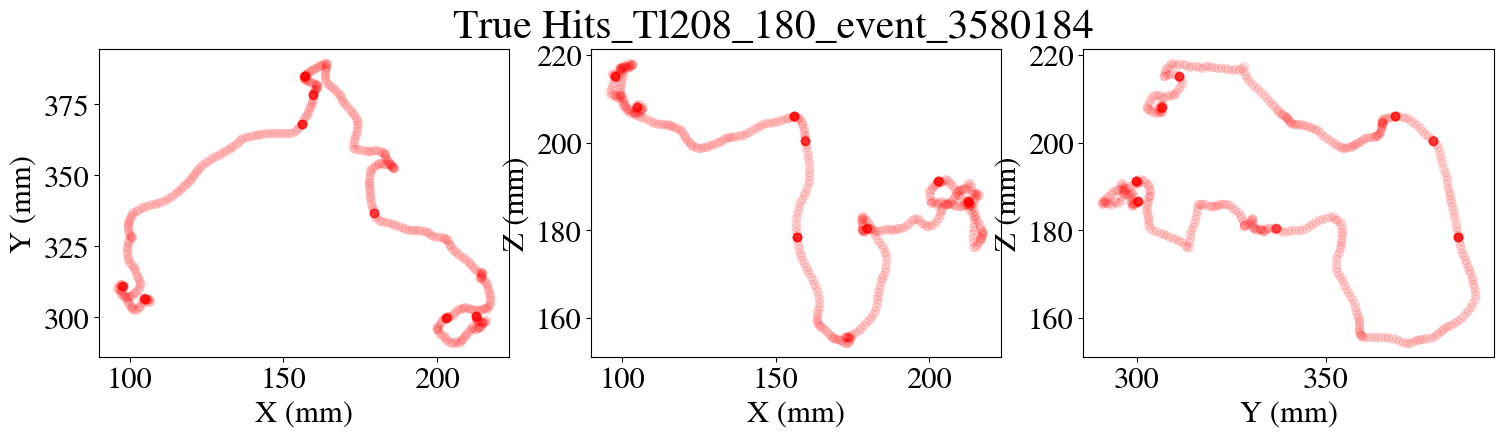

In [24]:
# true data type plots
if (datatype == 'MC'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + dir_name, fontsize=30)
    fig.savefig(pre_dir_name + dir_name + "/MC_hits")

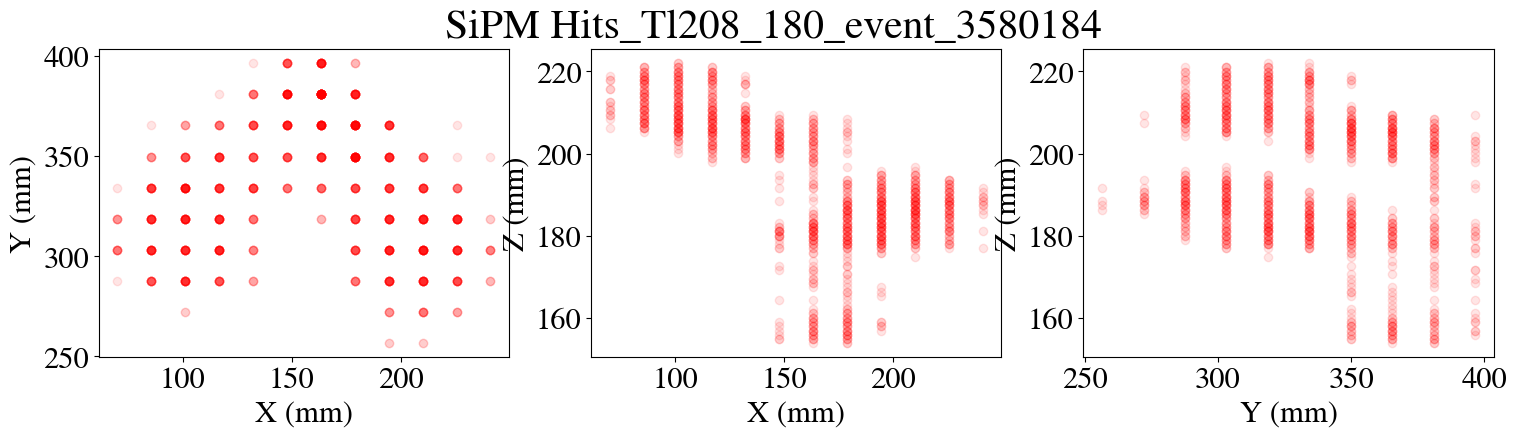

In [25]:
# plotting sipm data normally
# true data type plots

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")

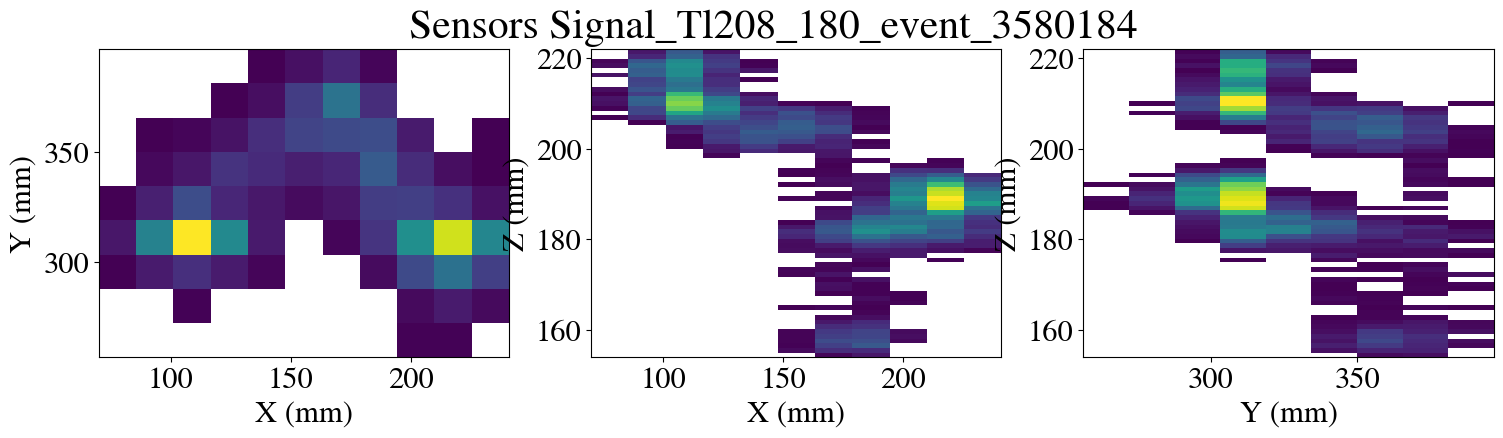

In [26]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")

#### Cut sensors

 Cut sensors below a given threshold, this cleans the signal and removes hits considered not part of the image. It can be seen that the cut does not harm the image noticeably.

In [27]:
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')

Cutting sensors below 7


In [28]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.02219843864440918 s


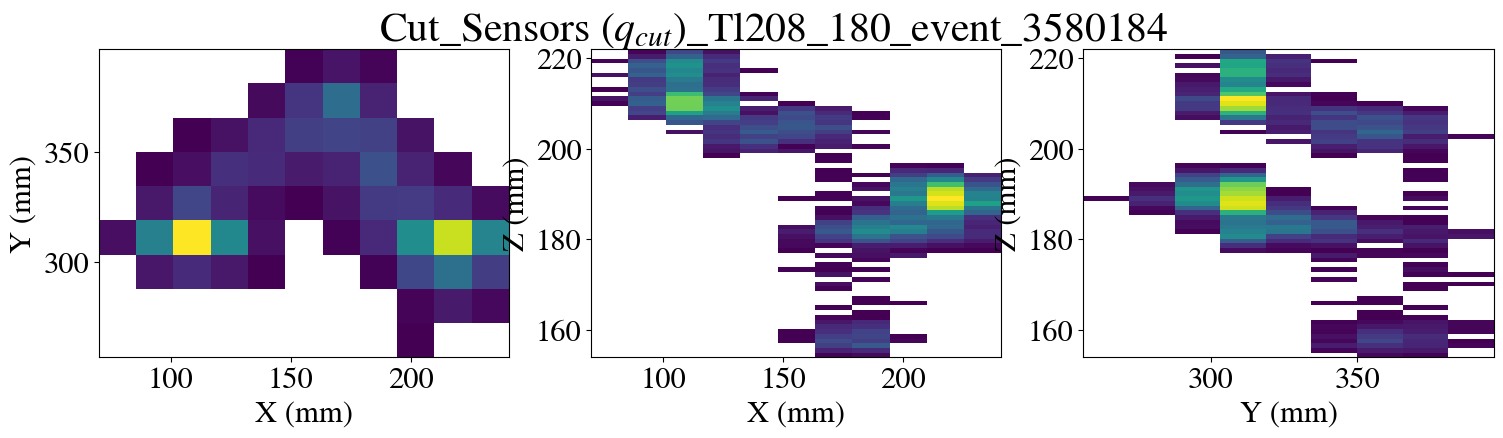

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")

Increased cut to see the impact of the function on higher thresholds:

In [30]:
cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())

Time spent in cut_over_Q: 0.029195547103881836 s


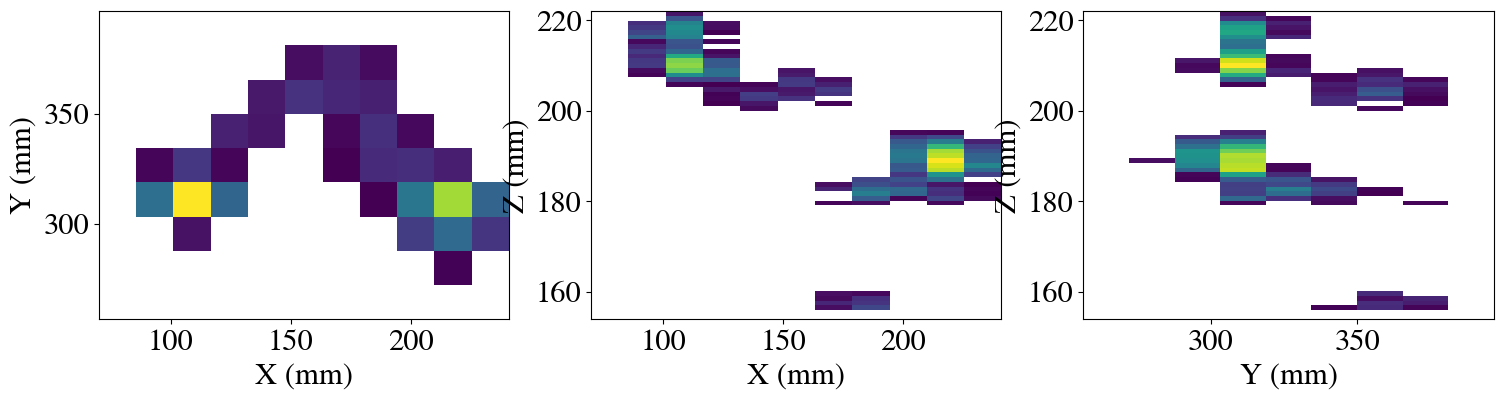

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the remaining hits so the total energy of the event remains the same:

In [32]:
print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')

Energy (corrected) before cuts:    490590.00385841954 (1.5969519152853375)
Energy (corrected) after low cut:  490590.00385841954 (1.5969519152853373)
Energy (corrected) after high cut: 490590.0038584196 (1.5969519152853375)


#### Drop isolated sensors

Cut sensors that are isolated in XY. Basically drops a sensor if there are no sensors near-by (distance can be configurable) that have seen light in the event.

In [33]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.029727935791015625 s


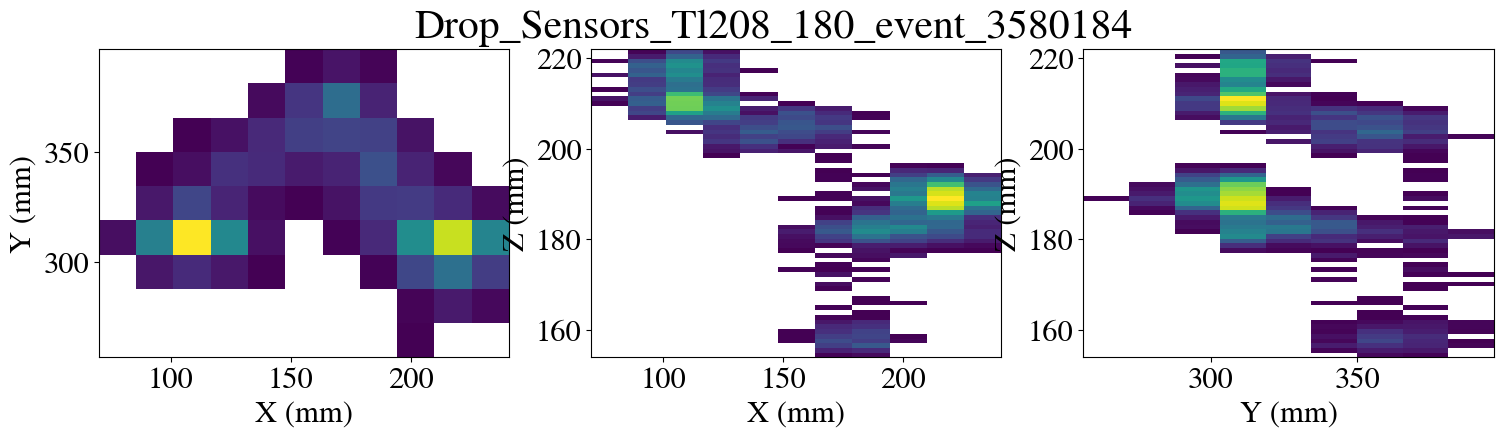

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")


It usually does not make a difference, as it's not usual to have rogue SiPMs. Let's add one and check the performance of the function:

In [35]:
hits_cut.loc[len(hits_cut)] = hits_cut.loc[0].values
hits_cut.loc[len(hits_cut)-1, ['X', 'Y', 'Q']] = [-250, -250, 1000]

In [36]:
hits_cut.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
630,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,101.075,318.775,0.0,0.0,220.948196,28.579710,1173.090430,-1.0,0.003739,-1.0,-1.0
631,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,116.625,303.225,0.0,0.0,220.948196,8.115942,333.129129,-1.0,0.001062,-1.0,-1.0
632,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,116.625,318.775,0.0,0.0,220.948196,9.449275,387.857473,-1.0,0.001236,-1.0,-1.0
633,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,101.075,318.775,0.0,0.0,221.989685,13.043478,1555.435334,-1.0,0.004959,-1.0,-1.0
634,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,-250.000,-250.000,0.0,0.0,153.902756,1000.000000,1090.965504,-1.0,0.003672,-1.0,-1.0


### be not afraid of these plots, notebook-wanderer. For these are purposefully crap to demonstrate how to modify the event

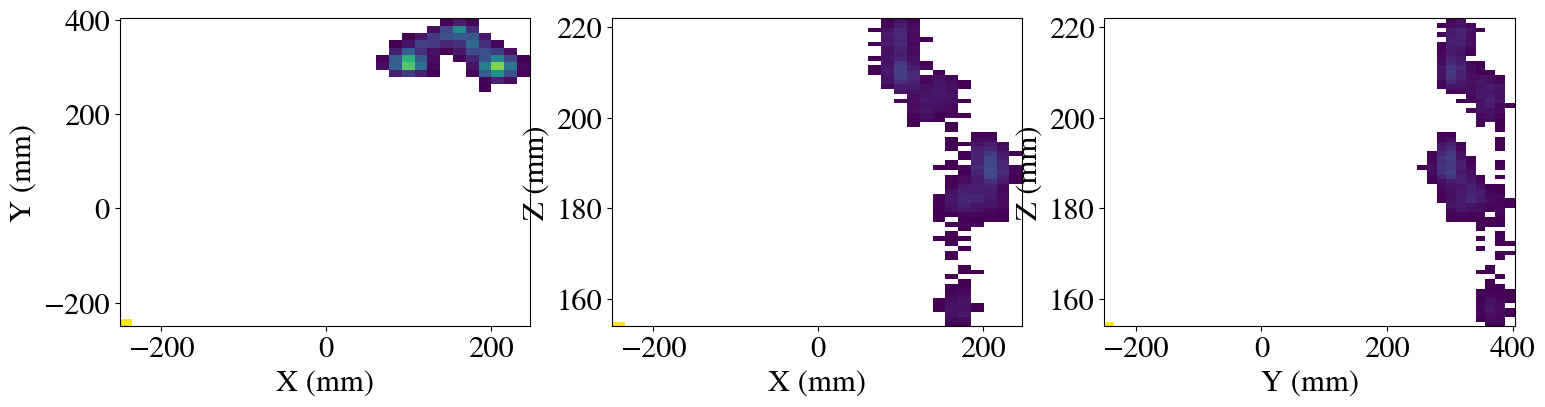

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + pitch, pitch)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



And now after cut:


In [38]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.03609299659729004 s


In [39]:
hits_drop.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,153.902756,12.637681,1093.391574,-1.0,0.003681,-1.0,-1.0
1,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,380.975,0.0,0.0,153.902756,8.115942,702.178081,-1.0,0.002403,-1.0,-1.0
2,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,365.425,0.0,0.0,154.910446,15.130435,659.833956,-1.0,0.002222,-1.0,-1.0
3,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,349.875,0.0,0.0,154.910446,9.739130,424.720683,-1.0,0.001389,-1.0,-1.0
4,3580184.0,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,154.910446,11.884058,518.260381,-1.0,0.001745,-1.0,-1.0


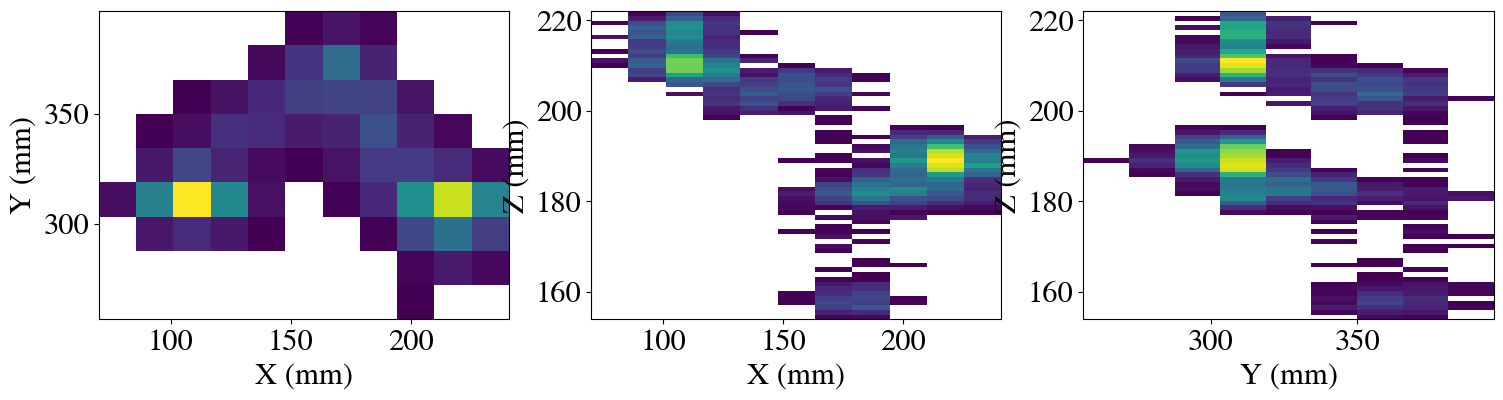

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same. The increment is due to the additional hit to hits_copy which caused an increase in the input energy. Still the energy before and after the cut remains the same as should be expected.

In [41]:
print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')

Energy (corrected) before cut: 491680.969362797 (1.600624400747547)
Energy (corrected) after  cut: 491680.969362797 (1.600624400747547)


Recover the hits as they should (normal cuts):

In [42]:
hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.028095245361328125 s
Time spent in drop_isolated: 0.023847579956054688 s


#### Deconvolve Signal 

Last function in the city is deconvolve_signal which basically chooses the deconvolution mode (either 2D or 3D, and joint or separate, see code description) and calls deconvolve function (once per S2 peak). Which first interpolates the signal and then deconvolves it. After all the process, deconvolve_signal assigns the energy, measured by the PMTs (corrected or not, chosen by parameter) to each deconvolved hit based on their fraction of energy of the full S2 peak.

Hereunder, deconvolve_signal output will be showed. Individual performance of each step will be looked into later in the notebook.

In [43]:
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in apply_deconvolution: 10.73161268234253 s


In [44]:
# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']
print(save_state)

100


In [45]:


for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

15 iterations
Time spent in apply_deconvolution: 2.200627565383911 s
30 iterations
Time spent in apply_deconvolution: 3.501939058303833 s
45 iterations
Time spent in apply_deconvolution: 5.133157968521118 s
60 iterations
Time spent in apply_deconvolution: 6.5357584953308105 s
75 iterations
Time spent in apply_deconvolution: 7.965184926986694 s
90 iterations
Time spent in apply_deconvolution: 13.84695029258728 s


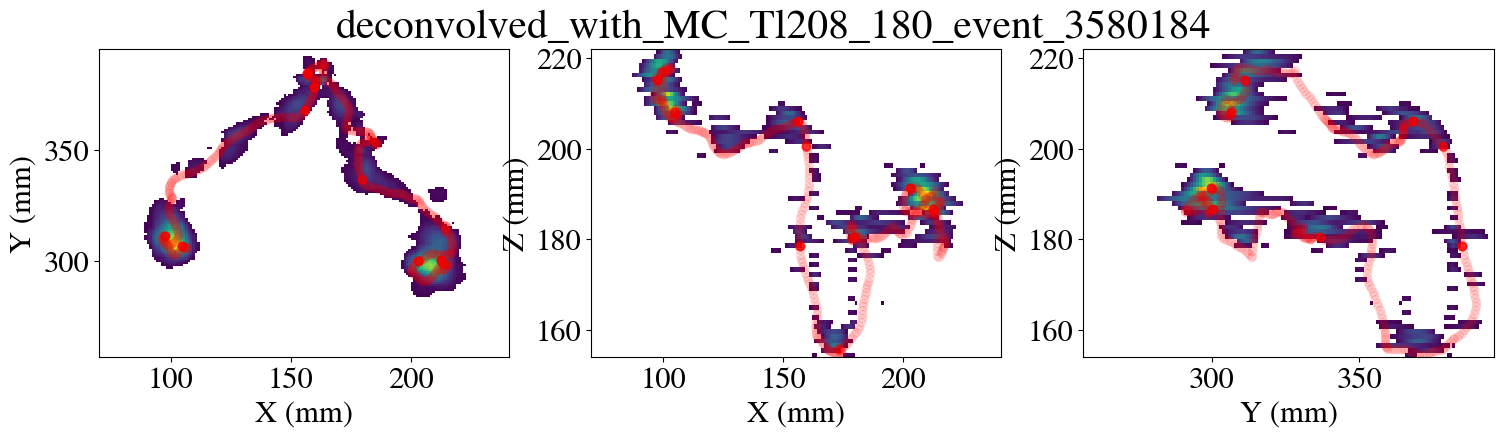

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")

In [47]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E*1000

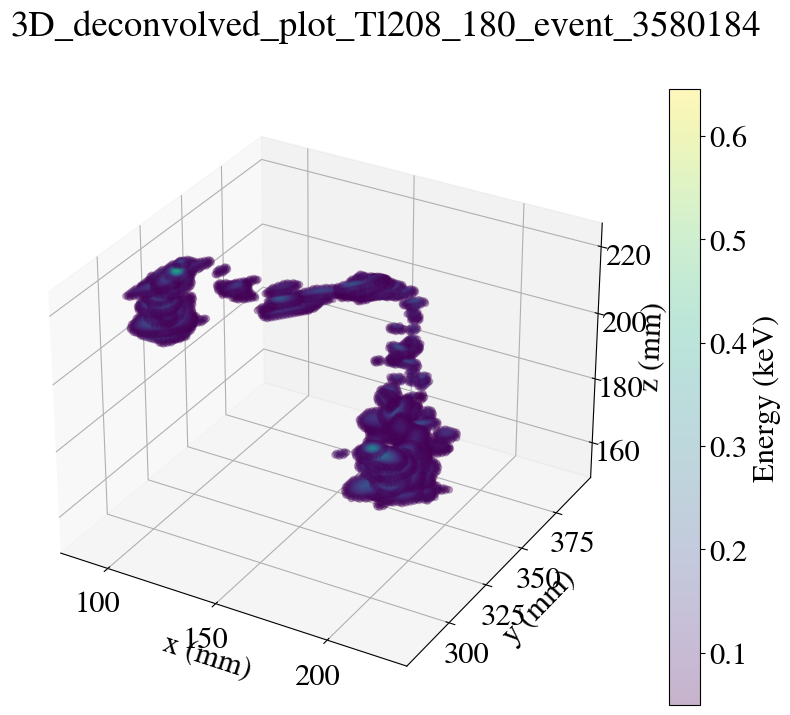

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

plt.show()

/tmp/ipykernel_18136/4182008797.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


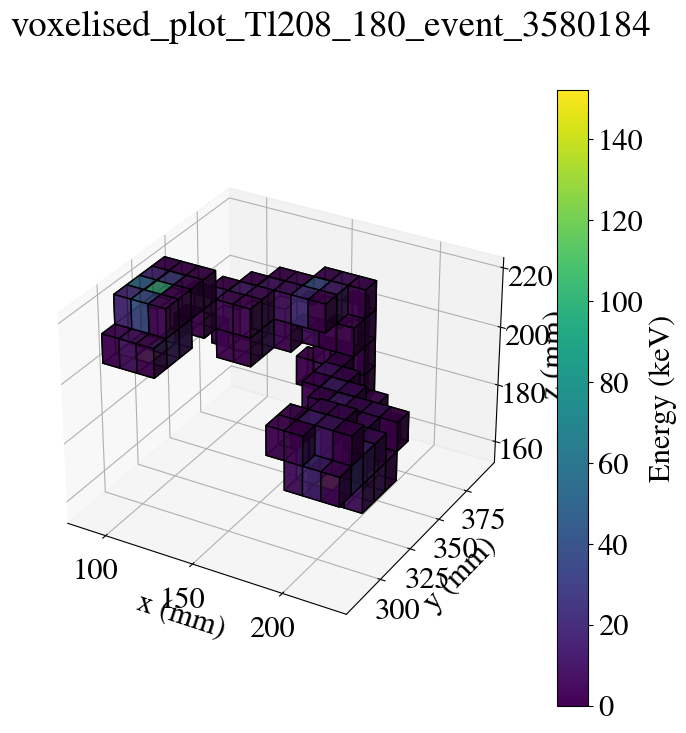

In [49]:
base_vsize = 10 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

plt.show()

In [50]:
hits_deco.head()

,event,npeak,X,Y,Z,E
0,3580184,0.0,162.675,379.675,153.902756,0.000051
1,3580184,0.0,162.675,380.675,153.902756,0.000062
2,3580184,0.0,162.675,381.675,153.902756,0.000053
3,3580184,0.0,163.675,379.675,153.902756,0.000058
4,3580184,0.0,163.675,380.675,153.902756,0.000059


In [51]:
display(hits_drop.head())
(print(hits_drop.Ec.sum()))

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,153.902756,12.637681,1090.965504,-1,0.003672,-1,-1
1,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,380.975,0.0,0.0,153.902756,8.115942,700.620055,-1,0.002397,-1,-1
2,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,365.425,0.0,0.0,154.910446,15.130435,658.369885,-1,0.002216,-1,-1
3,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,349.875,0.0,0.0,154.910446,9.739130,423.778293,-1,0.001385,-1,-1
4,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,154.910446,11.884058,517.110440,-1,0.001741,-1,-1


1.5969519152853373


In [52]:
display(true_info)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,3580000,33,0,-46.194996,467.190399,431.942200,1.535779,0.000067,ACTIVE
1,3580000,33,1,-55.469902,471.587219,515.781616,1.817526,0.000070,ACTIVE
2,3580000,33,2,-260.563843,156.963150,379.097809,3.150674,0.000209,ACTIVE
3,3580000,58,0,-260.563843,156.963150,379.097809,3.150674,0.000021,ACTIVE
4,3580000,57,0,-260.563843,156.963043,379.097778,3.150701,0.000044,ACTIVE
...,...,...,...,...,...,...,...,...,...
125194,3580710,11,66,465.195312,47.502777,655.698425,1.556505,0.001955,ACTIVE
125195,3580710,11,67,465.203644,47.507076,655.708740,1.556792,0.001550,ACTIVE
125196,3580710,11,68,465.208984,47.499176,655.710632,1.557019,0.001224,ACTIVE
125197,3580710,11,69,465.209167,47.492569,655.711853,1.557197,0.002001,ACTIVE


In [53]:
break;

SyntaxError: 'break' outside loop (1693679151.py, line 1)

### Create a loop that does it all

In [ ]:
#

In [17]:
for i in range(len(hdst.event.unique())):
	evt = hdst.event.unique()[i+90]
	hits = hdst[hdst.event == evt]
	
	x_range = (hits.X.max()-hits.X.min())/2.
	y_range = (hits.Y.max()-hits.Y.min())/2.
	z_range = (hits.Z.max()-hits.Z.min())/2.
	mid_x   = (hits.X.max()+hits.X.min())/2.
	mid_y   = (hits.Y.max()+hits.Y.min())/2.
	mid_z   = (hits.Z.max()+hits.Z.min())/2.

	print("X maximum and minimum")
	print(hits.X.max(), hits.X.min())
	print("")

	print("Y maximum and minimum")
	print(hits.Y.max(), hits.Y.min())
	print("")

	print("Z maximum and minimum")
	print(hits.Z.max(), hits.Z.min())

	xbins = int(hits.X.max()-hits.X.min())
	ybins = int(hits.Y.max()-hits.Y.min())
	zbins = int((hits.Z.max()-hits.Z.min())/2.)
	
	
	if (datatype == 'MC'):
	    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
	    true_info = mcio.load_mchits_df(soph_file).reset_index()
	    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
	    
	    
	    this_evt_true_info = true_info[true_info.event_id == evt]

	    xt = this_evt_true_info.x
	    yt = this_evt_true_info.y
	    zt = this_evt_true_info.z
	    et = this_evt_true_info.energy*1000
	
	no = this_evt_true_info['event_id'].to_numpy()[0]
	file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
	dir_name = "Tl208_" + file_number + "_event_" + str(no)

	pre_dir_name = 'beersheba_event_plots/'

	if not os.path.isdir(pre_dir_name + dir_name):
	    os.mkdir(pre_dir_name +dir_name)
	
	
	# true data type plots
	if (datatype == 'MC'):
	    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	    axes[0].set_xlabel('X (mm)');
	    axes[0].set_ylabel('Y (mm)');

	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	    axes[1].set_xlabel('X (mm)');
	    axes[1].set_ylabel('Z (mm)');

	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	    axes[2].set_xlabel('Y (mm)');
	    axes[2].set_ylabel('Z (mm)');
	    
	    fig.suptitle('True Hits_' + dir_name, fontsize=30)
	    fig.savefig(pre_dir_name + dir_name + "/MC_hits")
	    plt.close()
	   
	# plotting sipm data normally
	# true data type plots

	fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")
	plt.close()
	
	
	
	# then applying transformations to convert to 'SiPM outputs'
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))


	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")
	plt.close()
	
	
	qmin = deconv_params['q_cut']
	print(f'Cutting sensors below {qmin}')
	
	hits_cut = coref.timefunc(cut_sensors)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")
	plt.close()
	
	
	cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
	hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()
	
	
	print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
	print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')
	
	
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")
	plt.close()
	
	print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')
	
	hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	
	
	# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
	if 'save_state' in locals():
	    deconv_params_['n_iterations'] = save_state
	else:
	    # first time round, so set it
	    save_state = deconv_params_['n_iterations']
	print(save_state)
	
	
	
		
	for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
	    deconv_params_['n_iterations'] = iterN
	    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	    print(f'{iterN} iterations')
	    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	    
	    
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max())
	yy = np.arange(hits.Y.min(), hits.Y.max())
	zz = hits.Z.unique()

	axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()


	fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")
	
	x = hits_deco.X
	y = hits_deco.Y
	z = hits_deco.Z
	e = hits_deco.E*1000
	
	
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')

	p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
	cb = fig.colorbar(p, ax=ax)
	cb.set_label('Energy (keV)')

	ax.set_xlabel('x (mm)')
	ax.set_ylabel('y (mm)')
	ax.set_zlabel('z (mm)')

	fig.suptitle('3D_deconvolved_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

	plt.close()
	
	# voxel size here
	base_vsize = 15 #mm
	the_hits = []

	xs = hits_deco.X
	ys = hits_deco.Y
	zs = hits_deco.Z
	es = hits_deco.E

	for x, y, z, e in zip(xs, ys, zs, es):
	    if np.isnan(e): continue
	    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
	    the_hits.append(h)

	voxels = voxelize_hits(the_hits,
		               np.array([base_vsize, base_vsize, base_vsize]), False)

	vsizex = voxels[0].size[0]
	vsizey = voxels[0].size[1]
	vsizez = voxels[0].size[2]

	min_corner_x = min(v.X for v in voxels) - vsizex/2.
	min_corner_y = min(v.Y for v in voxels) - vsizey/2.
	min_corner_z = min(v.Z for v in voxels) - vsizez/2.

	x = [np.round(v.X/vsizex) for v in voxels]
	y = [np.round(v.Y/vsizey) for v in voxels]
	z = [np.round(v.Z/vsizez) for v in voxels]
	e = [v.E for v in voxels]

	x_min = int(min(x))
	y_min = int(min(y))
	z_min = int(min(z))

	x_max = int(max(x))
	y_max = int(max(y))
	z_max = int(max(z))

	#print(f'X min = {x_min}, X max = {x_max}')
	#print(f'Y min = {y_min}, Y max = {y_max}')
	#print(f'Z min = {z_min}, Z max = {z_max}')

	VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
	#print(VOXELS.shape)

	# sort through the event set the "turn on" the hit voxels
	cmap = cm.viridis
	norm = Normalize(vmin=0, vmax=max(e))

	colors = np.empty(VOXELS.shape, dtype=object)
	for q in range(0,len(z)):
	    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
	    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

	# and plot everything
	fig = plt.figure(figsize=(8,8))
	ax = fig.gca(projection='3d')
	#a,b,c is spacing in mm needs an extra dim
	a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
	a = a*vsizex + min_corner_x
	b = b*vsizey + min_corner_y
	c = c*vsizez + min_corner_z

	# a, b, c are the corners of the voxels
	ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

	ax.set_xlabel('x (mm)')#,fontsize=16)
	ax.set_ylabel('y (mm)')#,fontsize=16)
	ax.set_zlabel('z (mm)')#,fontsize=16)

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cb = fig.colorbar(sm)
	cb.set_label('Energy (keV)')

	fig.suptitle('voxelised_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

	plt.close()

X maximum and minimum
241.025 69.975

Y maximum and minimum
396.525 256.575

Z maximum and minimum
221.98968505859375 153.9027557373047
Cutting sensors below 5
Time spent in cut_over_Q: 0.015340805053710938 s
Time spent in cut_over_Q: 0.018148422241210938 s
Energy (corrected) before cuts:    490590.00385841954 (1.5969519152853375)
Energy (corrected) after low cut:  490590.00385841954 (1.5969519152853375)
Energy (corrected) after high cut: 490590.0038584196 (1.5969519152853375)
Time spent in drop_isolated: 0.03551197052001953 s
Energy (corrected) before cut: 490590.00385841954 (1.5969519152853375)
Energy (corrected) after  cut: 490590.00385841954 (1.5969519152853375)
Time spent in cut_over_Q: 0.011686325073242188 s
Time spent in drop_isolated: 0.016998767852783203 s
Time spent in apply_deconvolution: 8.77209734916687 s
100
15 iterations
Time spent in apply_deconvolution: 1.9434130191802979 s
30 iterations
Time spent in apply_deconvolution: 2.996838092803955 s
45 iterations
Time spent in

/tmp/ipykernel_31917/2101591017.py:341: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


X maximum and minimum
396.525 54.425

Y maximum and minimum
458.725 272.125

Z maximum and minimum
578.9918823242188 516.0628662109375
Cutting sensors below 5
Time spent in cut_over_Q: 0.03516030311584473 s
Time spent in cut_over_Q: 0.01817798614501953 s
Energy (corrected) before cuts:    105130.99870483472 (0.4198091671128144)
Energy (corrected) after low cut:  105130.99870483472 (0.4198091671128144)
Energy (corrected) after high cut: 105130.99870483474 (0.41980916711281435)
Time spent in drop_isolated: 0.012527942657470703 s
Energy (corrected) before cut: 105130.99870483472 (0.4198091671128144)
Energy (corrected) after  cut: 105130.99870483472 (0.4198091671128144)
Time spent in cut_over_Q: 0.01805901527404785 s
Time spent in drop_isolated: 0.010131120681762695 s
Time spent in apply_deconvolution: 2.302119493484497 s
100
15 iterations
Time spent in apply_deconvolution: 0.6189408302307129 s
30 iterations
Time spent in apply_deconvolution: 0.8914480209350586 s
45 iterations
Time spent i

KeyboardInterrupt: 